In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn import linear_model, metrics, preprocessing
from sklearn.feature_selection import RFE,SelectPercentile,f_classif,chi2
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

### Load data

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

### Remove constant columns

In [3]:
remove = []
for col in df_train.columns:
    if df_train[col].std() == 0:
        remove.append(col)

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

### Remove duplicated columns

In [4]:
remove = []
c = df_train.columns
for i in range(len(c)-1):
    v = df_train[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,df_train[c[j]].values):
            remove.append(c[j])

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

### Other cleaning

In [5]:
# Replace -999999 in var3 column with most common value 2 
df_train = df_train.replace(-999999,2)
df_test = df_test.replace(-999999,2)

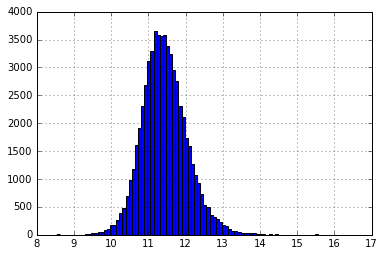

In [6]:
# What are the most common values for var38 ?
# df_train.var38.value_counts()
# df_test.var38.value_counts()

df_train.loc[~np.isclose(df_train.var38, 117310.979016), 'var38'].map(np.log).hist(bins=100)
# df_test.loc[~np.isclose(df_test.var38, 117310.979016), 'var38'].map(np.log).hist(bins=100)

In [7]:
df_train['var38mc'] = np.isclose(df_train.var38, 117310.979016)
df_train['logvar38'] = df_train.loc[~df_train['var38mc'], 'var38'].map(np.log)
df_train.loc[df_train['var38mc'], 'logvar38'] = 0

df_test['var38mc'] = np.isclose(df_test.var38, 117310.979016)
df_test['logvar38'] = df_test.loc[~df_test['var38mc'], 'var38'].map(np.log)
df_test.loc[df_test['var38mc'], 'logvar38'] = 0

df_train=df_train.drop('var38', 1)
df_test=df_test.drop('var38', 1)

### Feature selection

In [20]:
Xdf_tr = df_train.drop('TARGET', 1)
tdf_tr = df_train.TARGET

from sklearn.preprocessing import Binarizer, scale

p = 52 # percentage of selected features

X_bin = Binarizer().fit_transform(scale(Xdf_tr))
selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, tdf_tr)
selectF_classif = SelectPercentile(f_classif, percentile=p).fit(Xdf_tr, tdf_tr)

chi2_selected = selectChi2.get_support()
chi2_selected_features = [ f for i,f in enumerate(Xdf_tr.columns) if chi2_selected[i]]

f_classif_selected = selectF_classif.get_support()
f_classif_selected_features = [ f for i,f in enumerate(Xdf_tr.columns) if f_classif_selected[i]]


selected = chi2_selected | f_classif_selected
print('Chi2 & F_classif selected {} features'.format(selected.sum()))
features = [ f for f,s in zip(Xdf_tr.columns, selected) if s]

print('List of features:{}'.format(features))
Xdf=df_train[features]

Chi2 & F_classif selected 180 features
List of features:['var3', 'var15', 'imp_op_var39_comer_ult1', 'imp_op_var40_efect_ult1', 'imp_op_var40_efect_ult3', 'imp_op_var41_comer_ult1', 'imp_op_var41_efect_ult1', 'imp_op_var41_efect_ult3', 'imp_op_var41_ult1', 'imp_op_var39_efect_ult1', 'imp_op_var39_efect_ult3', 'imp_op_var39_ult1', 'imp_sal_var16_ult1', 'ind_var1', 'ind_var5_0', 'ind_var5', 'ind_var8_0', 'ind_var8', 'ind_var12_0', 'ind_var12', 'ind_var13_0', 'ind_var13_corto_0', 'ind_var13_corto', 'ind_var13_largo_0', 'ind_var13_largo', 'ind_var13', 'ind_var14_0', 'ind_var14', 'ind_var17_0', 'ind_var19', 'ind_var20_0', 'ind_var20', 'ind_var24_0', 'ind_var24', 'ind_var25_cte', 'ind_var26_0', 'ind_var26_cte', 'ind_var25_0', 'ind_var30_0', 'ind_var30', 'ind_var31_0', 'ind_var31', 'ind_var33_0', 'ind_var33', 'ind_var39_0', 'ind_var40', 'ind_var41_0', 'ind_var44_0', 'ind_var44', 'num_var1', 'num_var4', 'num_var5_0', 'num_var5', 'num_var8_0', 'num_var8', 'num_var12_0', 'num_var12', 'num_var13_

### Extract training data

In [21]:
#from sklearn import preprocessing
#X_tr = preprocessing.scale(Xdf.as_matrix())

X_tr = Xdf.as_matrix()
t_tr = df_train['TARGET'].as_matrix()

# Split up the data
X_fit, X_eval, t_fit, t_eval = train_test_split(X_tr, t_tr, test_size=0.25, random_state=42)

N_tr=np.shape(X_tr)[0]
D=np.shape(X_tr)[1]

In [28]:
# classifier
# http://xgboost.readthedocs.org/en/latest/parameter.html
# http://xgboost.readthedocs.org/en/latest/param_tuning.html
clf = xgb.XGBClassifier(
      objective= 'binary:logistic',    
      learning_rate=0.016, 
      n_estimators=750,
      max_depth=7,
      subsample=0.85,
      colsample_bytree=0.85,
      nthread=4,
      silent = 1,
      seed=8
)
# best observed: learning_rate=0.0175, n_estimators=400,max_depth=8,subsample=0.9,colsample_bytree=0.87,  seed=8
#clf = xgb.XGBClassifier(missing=np.nan, objective='binary:logistic', max_depth=8, n_estimators=170, 
#                        learning_rate=0.02, nthread=4, subsample=0.90, colsample_bytree=0.87,seed=8)

X_fit, X_eval, t_fit, t_eval= train_test_split(X_tr, t_tr, test_size=0.25,random_state=42)

# fitting
clf.fit(X_fit, t_fit, early_stopping_rounds=50, eval_metric="auc", eval_set=[(X_eval, t_eval)])

# Predict training data
t_hat_fit = clf.predict_proba(X_fit)[:,1]

# Predict test data
t_hat_eval = clf.predict_proba(X_eval)[:,1]

# Print model report:
print("\nModel Report")
print("AUC Score (Train): %f" % roc_auc_score(t_fit, t_hat_fit))
print("AUC Score (Test) : %f" % roc_auc_score(t_eval,  t_hat_eval))

Will train until validation_0 error hasn't decreased in 50 rounds.
[0]	validation_0-auc:0.691167
[1]	validation_0-auc:0.765889
[2]	validation_0-auc:0.773376
[3]	validation_0-auc:0.779304
[4]	validation_0-auc:0.771105
[5]	validation_0-auc:0.776200
[6]	validation_0-auc:0.780948
[7]	validation_0-auc:0.778705
[8]	validation_0-auc:0.781023
[9]	validation_0-auc:0.782267
[10]	validation_0-auc:0.783148
[11]	validation_0-auc:0.784262
[12]	validation_0-auc:0.787383
[13]	validation_0-auc:0.788769
[14]	validation_0-auc:0.789533
[15]	validation_0-auc:0.789713
[16]	validation_0-auc:0.790418
[17]	validation_0-auc:0.791126
[18]	validation_0-auc:0.790268
[19]	validation_0-auc:0.785257
[20]	validation_0-auc:0.787036
[21]	validation_0-auc:0.787087
[22]	validation_0-auc:0.783973
[23]	validation_0-auc:0.785017
[24]	validation_0-auc:0.787162
[25]	validation_0-auc:0.787979
[26]	validation_0-auc:0.789861
[27]	validation_0-auc:0.790360
[28]	validation_0-auc:0.790749
[29]	validation_0-auc:0.789002
[30]	validati


Model Report
AUC Score (Train): 0.932299
AUC Score (Test) : 0.835664


Stopping. Best iteration:
[492]	validation_0-auc:0.832065



In [65]:
clf.fit(X_tr, t_tr, early_stopping_rounds=50, eval_metric="auc", eval_set=[(X_eval, t_eval)])
X_test = df_test[features].as_matrix()
t_pred=clf.predict_proba(X_test)[:,1]
plt.plot(t_pred)

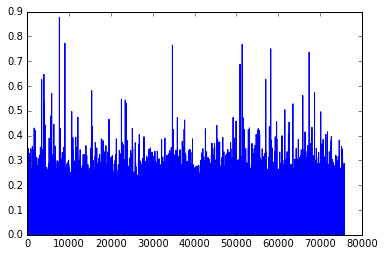

In [67]:
id_test = df_test['ID']
submission = pd.DataFrame({"ID":id_test, "TARGET": t_pred})
submission.to_csv("./data/submission.csv", index=False)